# Embedding 数据准备

上一节中，我们已经开发了一个 FastAPI 推理服务，用于将图片转成 DINOv2 推理的 Embedding。

本节我们来做数据准备。首先下载 CIFAR-100 数据集，它是一个由 100 类图片组成的图片分类数据集，其中训练集有 5 万张图片，测试集有 1 万张图片。下载完成后，使用上一节搭建的 FastAPI 服务，将图片转成 Embedding，然后用 csv 格式存储 Embedding 和对应标签。

为了方便 DataFrame 和 csv 之间的转换，我开发了两个工具函数，见 `utils.py`：

- `embedding_df_to_csv()`: 将 DataFrame 存入 csv
- `read_embedding_csv()`: 从 csv 读入 DataFrame

In [13]:
import io
import os
import base64
import pickle
import requests
import numpy as np
import pandas as pd

import utils

from concurrent.futures import ThreadPoolExecutor
from typing import List, Optional
from PIL import Image
from IPython.display import display

CIFAR_PATH = 'data/cifar-100-python/'
API_URL = 'http://localhost:8210/embeddings/'
SAMPLE_NUM = 10000
CSV_PATH = './data'

## 1. 下载 CIFAR-100 数据集

打开 CIFAR-100 数据集下载页 ([https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html))，点击链接 [CIFAR-100 python version](https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz) 下载数据集。

将压缩包 `cifar-100-python.tar.gz` 放在项目的 `./data` 路径下并解压：

```bash
cd data
tar -xvzf cifar-100-python.tar.gz
```

In [14]:
def load_cifar100_batch(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')

    # 解析数据
    images = data[b'data']
    labels = data[b'fine_labels']  # 细粒度标签（100类）

    # 转换图像格式（3072=32x32x3）
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return images, labels

def preprocess_image(image):
    # 若数据格式为 CHW（如 CIFAR-100），转为 HWC
    if image.shape[0] in (1, 3):  # 灰度图或 RGB 图
        image = image.transpose(1, 2, 0)
    # 若数据被归一化到 [0, 1]，还原为 [0, 255]
    if np.max(image) <= 1.0:
        image = (image * 255).astype(np.uint8)
    return image

def show_image(idx):
    if idx < len(train_images):
        image = train_images[idx]
        image = preprocess_image(image)
        display(Image.fromarray(image))
    else:
        print(f'max idx: {len(train_images) - 1}')

In [15]:
# 加载训练集和测试集
train_images, train_labels = load_cifar100_batch(os.path.join(CIFAR_PATH, 'train'))
test_images, test_labels = load_cifar100_batch(os.path.join(CIFAR_PATH, 'test'))

len(train_images), len(test_images)

(50000, 10000)

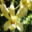

In [16]:
# 展示第 idx 张图片
show_image(idx=1231)

## 2. 图片转 Embedding

我们把图片转成 Embedding，然后用 DataFrame 将图片 Embedding 和图片标签存成一条记录。

启动 DINOv2 模型推理 API：

```bash
cd server
python dinov2_server.py
```

In [17]:
# 测试 API 连通性
image_paths = [
    './img/cat.jpg',
    './img/book.jpg'
]
base64_images = [utils.image_to_base64(p) for p in image_paths]
res = utils.client(base64_images, api_url=API_URL)
np.array(res.json().get('embeddings')).shape

(2, 768)

In [18]:
BATCH_SIZE = 8
MAX_WORKERS = 2

def to_base64(image):
    # 预处理图像
    image = preprocess_image(image)  

    # 编码为 Base64 字符串
    pil_img = Image.fromarray(image)
    buffer = io.BytesIO()  # 保存到内存缓冲区（格式可选 PNG/JPEG）
    pil_img.save(buffer, format="PNG")
    img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return img_base64

def split_list(lst, batch_size=BATCH_SIZE):
    return [lst[i:i + batch_size] for i in range(0, len(lst), batch_size)]

def batch_processor(images, max_tries=2):
    base64_images = [to_base64(e) for e in images]
    for _ in range(max_tries):
        response = utils.client(base64_images, api_url=API_URL)
        if response.status_code == 200:
            embeddings = response.json().get('embeddings')
            if len(embeddings) != len(images):
                print('Error: len(embeddings) != len(images)')
                break
            return embeddings
    return [None * len(images)]

def gen_image_embed(images):
    image_batches = split_list(images)

    results = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = executor.map(batch_processor, image_batches)
        for result in futures:
            results.extend(result)

    assert len(results) == len(images), f'len(results)={len(results)}, len(images)={len(images)}'
    return results

In [19]:
train_embeddings = gen_image_embed(images=train_images[:SAMPLE_NUM])

In [20]:
# 将 Embedding 和 label 存成 DataFrame
embed_df = pd.DataFrame({
    'embeddings': train_embeddings,
    'labels': train_labels[:SAMPLE_NUM]
})
embed_df.head()

,embeddings,labels
0,"[-0.04898432269692421, 0.004301051609218121, 0...",49
1,"[-0.030251776799559593, 0.054930735379457474, ...",33
2,"[0.018033478409051895, -0.0241413451731205, 0....",72
3,"[0.0965263620018959, 0.022365640848875046, 0.0...",51
4,"[-0.007981446571648121, -0.03037705458700657, ...",71


In [21]:
type(train_embeddings[0])

list

In [22]:
# 将 DataFrame 存成 csv
embed_csv_path = os.path.join(CSV_PATH, 'embed_label.csv')
utils.embedding_df_to_csv(df=embed_df,
                          csv_path=embed_csv_path,
                          ebd_cols=['embeddings'])

In [23]:
# 将 csv 读入 DataFrame
embed_df = utils.read_embedding_csv(csv_path=embed_csv_path,
                                    ebd_cols=['embeddings'])
len(embed_df)

10000

In [24]:
embed_df.head()

,embeddings,labels
0,"[-0.04898432269692421, 0.004301051609218121, 0...",49
1,"[-0.030251776799559593, 0.054930735379457474, ...",33
2,"[0.018033478409051895, -0.0241413451731205, 0....",72
3,"[0.0965263620018959, 0.022365640848875046, 0.0...",51
4,"[-0.007981446571648121, -0.03037705458700657, ...",71
